In [19]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.ensemble import VotingRegressor, BaggingRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

In [12]:
path = 'Dataset3/'
x1_train = pd.read_csv(path+'data_trainmid_x1.csv')
x2_train = pd.read_csv(path+'data_trainmid_x2.csv')
f1_train = pd.read_csv(path+'data_trainmid_f1.csv')
f1_test = pd.read_csv(path+'data_testmid_f1.csv')
x1_test = pd.read_csv(path+'data_testmid_x1.csv')
x2_test = pd.read_csv(path+'data_testmid_x2.csv')
print(len(x1_train),len(x1_test),len(f1_train),len(f1_test))
X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train),axis=1),columns = ['p1','p2'])
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test),axis=1),columns = ['p1','p2'])
X_train.head()

112459 62211 112459 62211


,p1,p2
0,-0.0000,-0.0000
1,-0.0159,-0.0000
2,-0.0159,0.0171
3,-0.0159,0.0171
4,-0.0000,0.0329


In [24]:
def get_results(t,m):
    l1 = len(X_train)
    l2 = len(X_test)
    x_train = [[0 for _ in range(m*2)] for _ in range(l1-t*(m-1))]
    x_test = [[0 for _ in range(m*2)] for _ in range(l2-t*(m-1))]

    for i in range(l1-t*(m-1)):
        for j in range(m):
            x_train[i][j]=X_train.iloc[t*(m-1)+i-2*j,0]
            x_train[i][j+m]=X_train.iloc[t*(m-1)+i-2*j,1]

    y_train = f1_train.iloc[t*(m-1):]

    for i in range(l2-t*(m-1)):
        for j in range(m):
            x_test[i][j]=X_test.iloc[t*(m-1)+i-2*j,0]
            x_test[i][j+m]=X_test.iloc[t*(m-1)+i-2*j,1]
    y_test = f1_test.iloc[t*(m-1):]
    x_train,x_test = np.array(x_train),np.array(x_test)
    
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    
    importances = rf.feature_importances_
    plt.figure(figsize=(20,5))
    x_plot = ['x1(n{})'.format(-i) for i in range(0,m*t,t)] + ['x2(n{})'.format(-i) for i in range(0,m*t,t)]
    plt.plot(x_plot,importances, label = 'Importance Plot')
    plt.legend()
    plt.xlabel('Feature')
    plt.ylabel('Feature importance')
    plt.title('Importance plot for random forest')
    plt.show()
    
    # RBF MODEL
    omp = OrthogonalMatchingPursuitCV(cv=5, normalize = False)
    model = BaggingRegressor(base_estimator = omp, n_estimators = 100)
    t1 = datetime.now()
    model.fit(x_train, y_train)
    t2 = datetime.now()

    print('Time taken by RBF Model: ',t2-t1)
    y1_pred = model.predict(x_test)
    y2 = y1_pred
    print('Root mean square error of RBF Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error5 = []
    for i in range(len(y_test)):
        error5.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error5))
    print('Maximum Error =',max(error5))
    error6 = sorted(error5)
    print('Median Value of Error =',error6[len(error5)//2])
    
    
    # SVR MODEL
    t1 = datetime.now()
    clf = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))
    clf.fit(x_train,y_train)
    t2 = datetime.now()

    print('\n\nTime taken by SVR Model: ',t2-t1)
    y1_pred = clf.predict(x_test)
    y4 = y1_pred
    print('Root mean square error of SVR Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error7 = []
    for i in range(len(y_test)):
        error7.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error7))
    print('Maximum Error =',max(error7))
    error8 = sorted(error7)
    print('Median Value of Error =',error8[len(error8)//2])
    
    # COMPARISON
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y2[:6000], label = 'RBF')
    plt.plot(list(range(6000)),y4[:6000], label = 'SVR')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    plt.plot(list(range(len(y1_pred))),error5, label = 'Error of RBF Model')
    plt.plot(list(range(len(y1_pred))),error, label = 'Error of Random Forest')
    plt.plot(list(range(len(y1_pred))),error7, label = 'Error of SVR Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    # closer view at initial points
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error7[:6000], label = 'SVR Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()

Time taken by Random Forest 0:02:24.315875
Root Mean Squared error of Random Forest 0.060145338665545986
Minimum Error = 1.6653345369377348e-16
Maximum Error = 0.9031940000000007
Median Value of Error = 0.018957000000000557


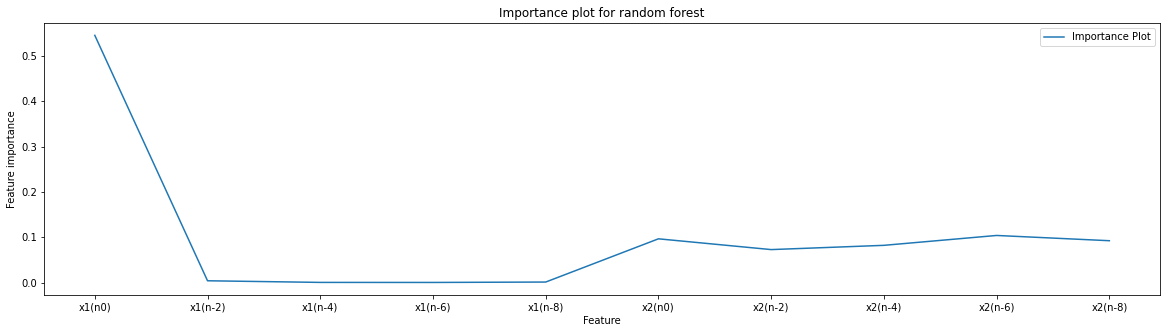

Time taken by RBF Model:  0:01:55.389117
Root mean square error of RBF Model:  0.2110238883700652
Minimum Error = 2.4847614485096203e-05
Maximum Error = 0.926671274696967
Median Value of Error = 0.2035274487997285


Time taken by SVR Model:  0:00:45.344599
Root mean square error of SVR Model:  0.050887983734934056
Minimum Error = 2.2642114055893003e-06
Maximum Error = 0.6910582720522933
Median Value of Error = 0.030619620841142225


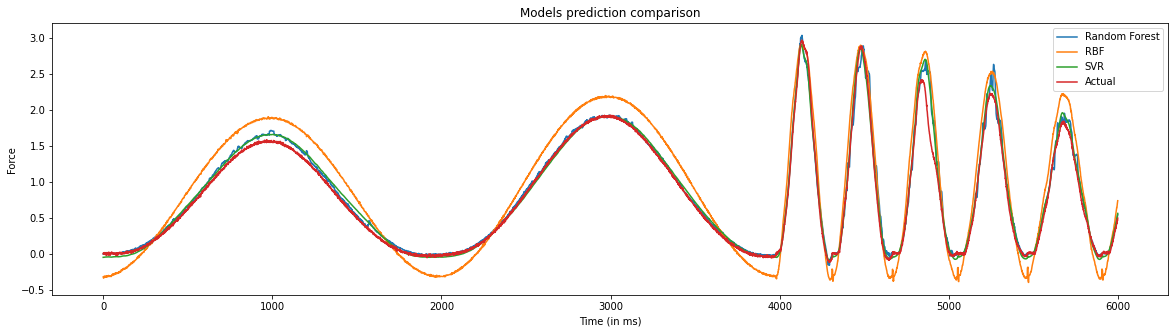

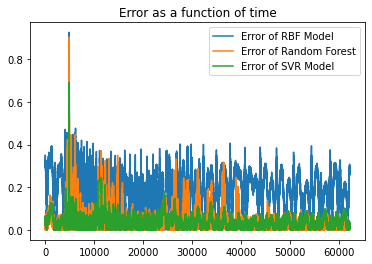

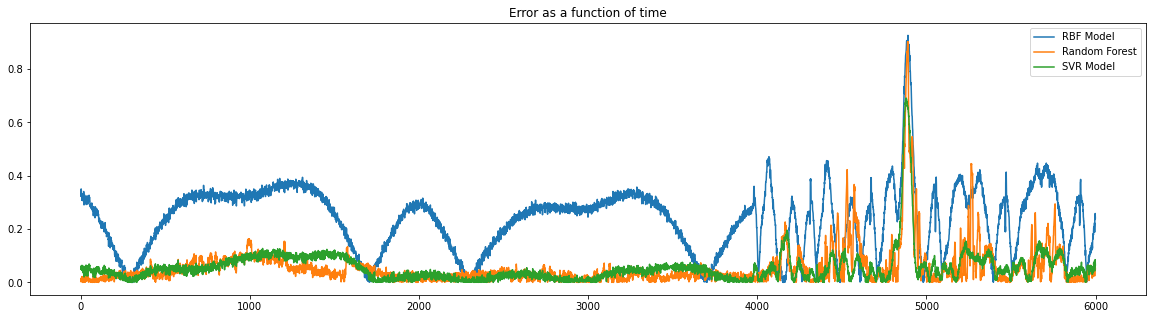

In [26]:
get_results(t=2, m=5)

Time taken by Random Forest 0:00:56.640968
Root Mean Squared error of Random Forest 0.06283175030451481
Minimum Error = 1.0000000000287557e-06
Maximum Error = 0.9268139999999991
Median Value of Error = 0.021069000000000337


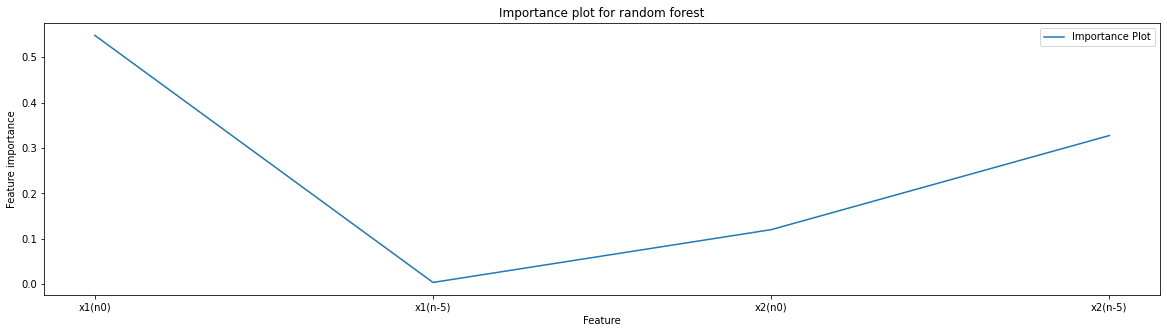

Time taken by RBF Model:  0:00:33.000938
Root mean square error of RBF Model:  0.2114072827437937
Minimum Error = 2.071934909669837e-06
Maximum Error = 0.9308261269744176
Median Value of Error = 0.20340252718344587


Time taken by SVR Model:  0:00:49.455493
Root mean square error of SVR Model:  0.05227482413233996
Minimum Error = 7.083062546903163e-07
Maximum Error = 0.6970765864572457
Median Value of Error = 0.03293862684839795


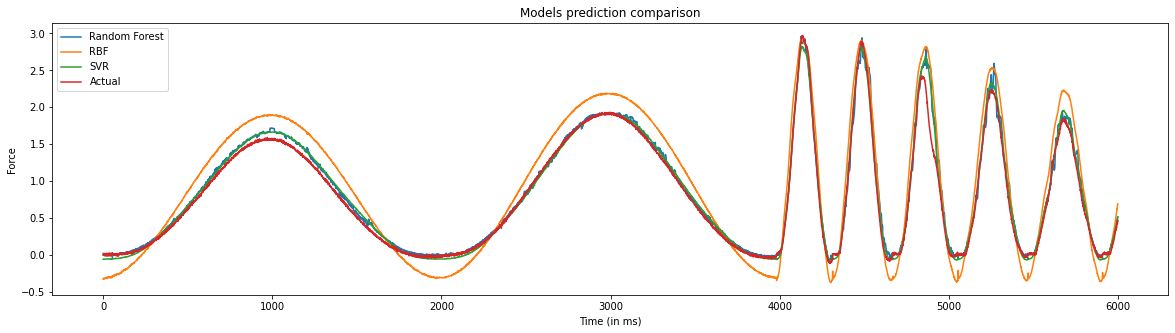

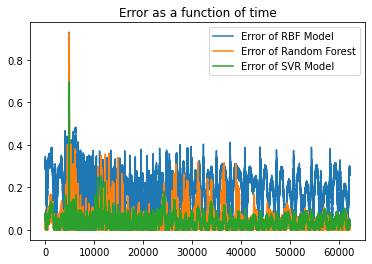

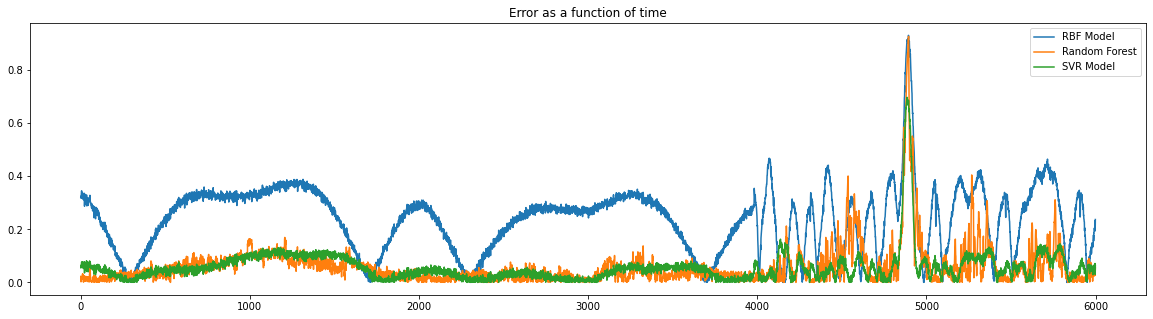

In [25]:
get_results(t=5, m=2)